In [1]:
# !wget -O train.tar.gz -q https://huggingface.co/datasets/project-sloth/captcha-images/resolve/main/data/train.tar.gz?download=true
# !wget -O test.tar.gz -q https://huggingface.co/datasets/project-sloth/captcha-images/resolve/main/data/test.tar.gz?download=true
# !wget -O validation.tar.gz -q https://huggingface.co/datasets/project-sloth/captcha-images/resolve/main/data/validation.tar.gz?download=true

In [2]:
# !gunzip *.tar.gz --force
# ! cat *.tar | tar -xf - -i
# !mkdir data
# !!mv test/ data/
# !mv train/ data/
# !mv validation/ data/

In [3]:
import silence_tensorflow.auto
import tensorflow as tf
gpuDevices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpuDevices))
tf.config.experimental.set_memory_growth(gpuDevices[0], True)
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})
# tf.config.run_functions_eagerly(True)
# tf.compat.v1.disable_eager_execution()
import keras
import os, sys, random, glob, time, logging, io
from PIL import Image

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

I0000 00:00:1725546516.559499   23898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725546516.598942   23898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725546516.604320   23898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Num GPUs Available:  1


In [4]:
batch_size = 32
image_shape = (50,200,3)

In [5]:

def decode_one_hot(one_hot_label):
    one_hot_reshaped = tf.reshape(one_hot_label, [6, 10])
    digits = tf.argmax(one_hot_reshaped, axis=-1)
    label = tf.strings.reduce_join(tf.strings.as_string(digits), axis=0)
    return label.numpy()


def decode_one_hot_2dim(one_hot_label):
    one_hot_reshaped = tf.reshape(one_hot_label, [6, 10])
    digits = tf.argmax(one_hot_reshaped, axis=1)
    return digits.numpy()


def plot_ds_unbatched(ds:tf.data.Dataset):
    plt.figure()
    dsit = iter(ds)
    for i in range(9):
        image, label = next(dsit)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"),cmap="gray")
        plt.title(label.numpy())
        plt.tight_layout()
        plt.axis("off")

def plot_ds_batched(ds:tf.data.Dataset):
    plt.figure()
    img_batch,label_batch = next(iter(ds))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img_batch[i].numpy().astype("uint8"),cmap="gray")
        plt.title(decode_one_hot_2dim(label_batch[i]))
        # plt.title(label_batch[i].numpy())
        
        plt.tight_layout()
        plt.axis("off")



In [6]:
def get_label(file_path: tf.Tensor):
  # print(file_pathx)
  parts = tf.strings.split(file_path, os.path.sep)
  # print(split(parts[-1], ".")[0])
  return tf.strings.split(parts[-1], ".")[0]

In [7]:
def label_to_one_hot(label):
    digits = tf.strings.to_number(tf.strings.unicode_split(label, 'UTF-8'), out_type=tf.int32)
    one_hot_digits = tf.one_hot(digits, depth=10)
    one_hot_label = tf.reshape(one_hot_digits, [-1])
    return one_hot_label

def label_to_one_hot_2d(label):
    digits = tf.strings.to_number(tf.strings.unicode_split(label, 'UTF-8'), out_type=tf.int32)
    one_hot_digits = tf.one_hot(digits, depth=10)
    return one_hot_digits


# Unit test:
test_label = tf.constant("123456", dtype=tf.string)
one_hot_result = label_to_one_hot_2d(test_label)
print(one_hot_result.numpy())
print(one_hot_result.numpy().shape)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(6, 10)


I0000 00:00:1725546517.097163   23898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725546517.102911   23898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725546517.106385   23898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725546517.257589   23898 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
def decode_img(img) -> tf.Tensor:
  return tf.io.decode_jpeg(img)

def preprocess_image(image:tf.Tensor) -> tf.Tensor:
  image = tf.cast(image, tf.float32)
  image = tf.image.adjust_contrast(image, 3)
  image =  tf.image.rgb_to_grayscale(image)
  image = tf.divide(tf.cast(image, dtype=tf.float32),tf.constant(255.0, dtype=tf.float32))
  return image

def preprocess_label(label : tf.Tensor) -> tf.Tensor:
  return label_to_one_hot_2d(label)

In [9]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [10]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return preprocess_image(img), preprocess_label(label)

tf.Tensor(6000, shape=(), dtype=int64)
188


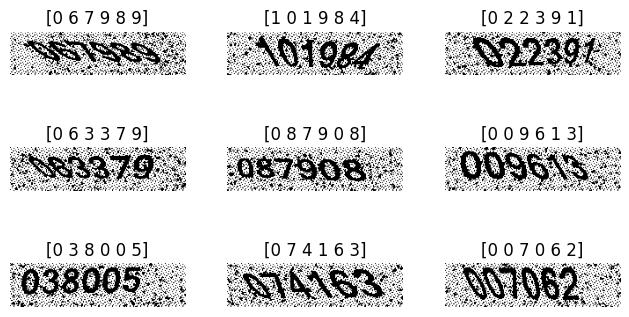

In [11]:
train_ds = tf.data.Dataset.list_files("./data/train/*.jpg", shuffle=False)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
print(train_ds.cardinality())

train_ds = configure_for_performance(train_ds)
print(train_ds.cardinality().numpy())
plot_ds_batched(train_ds)


In [12]:
loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
train_loss = keras.metrics.Mean(name='train_loss')
train_acc_metric = keras.metrics.CategoricalAccuracy(name='train_accuracy')


In [13]:
def make_encoder() :
    input_layer = keras.layers.Input(shape=(50,200,1))
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    
    x = keras.layers.Flatten(name='flatten_after_convs')(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(6 * 10, activation='softmax')(x)
    output_layer = keras.layers.Reshape((6, 10), name='final_reshape')(output_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=[train_acc_metric])
    
    model.summary()
    
    return model
        

model = make_encoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 200, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 100, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_after_convs (Flatten)   │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,830,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        30,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_reshape (Reshape)         │ (None, 6, 10)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,954,364 (37.97 MB)

 Trainable params: 9,954,364 (37.97 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print(model.input_shape)
print(model.output_shape)
print(model.dtype)
input, target = next(iter(train_ds.take(1)))
print(input.shape)
print(target.shape)
print(target.dtype)


(None, 50, 200, 1)
(None, 6, 10)
float32
(32, 50, 200, 1)
(32, 6, 10)
<dtype: 'float32'>


In [18]:
def create_dummy_dataset(num_samples=1000):
    # Create dummy input images (50x200x1)
    images = tf.random.normal(shape=(num_samples, 50, 200, 1))
    
    # Create dummy target labels (6 digits, one-hot encoded)
    labels = tf.random.uniform(shape=(num_samples, 6), minval=0, maxval=10, dtype=tf.int32)
    labels_one_hot = tf.one_hot(labels, depth=10)
    
    return images, labels_one_hot

In [20]:
images, labels = create_dummy_dataset(100)
print("Input shape:", images.shape)
print("Target shape:", labels.shape)

Input shape: (100, 50, 200, 1)
Target shape: (100, 6, 10)


In [28]:
dummy_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
for image, label in dummy_dataset.take(1):
    print("Single image shape:", image.shape)
    print("Single label shape:", label.shape)

dummy_dataset = dummy_dataset.batch(10)

Single image shape: (50, 200, 1)
Single label shape: (6, 10)


In [29]:
model.fit(dummy_dataset, epochs=1)

AttributeError: 'NoneType' object has no attribute 'items'

In [15]:
# @tf.function
# def train_step(x, y):
#     with tf.GradientTape() as tape:
#         logits = model(x, training=True)
#         loss_value = loss_fn(y, logits)
#     grads = tape.gradient(loss_value, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
#     return loss_value

In [16]:
# @tf.function
# def train(train_dataset, epochs):
#     for epoch in tf.range(epochs):
#         # Reset the metrics at the start of the next epoch
#         train_loss.reset_state()
#         train_acc_metric.reset_state()
        
#         for images, labels in train_dataset:
#             train_step(images, labels)
        
#         template = 'Epoch {}, Loss: {}, Accuracy: {}'
#         tf.print(template.format(epoch + 1,
#                                  train_loss.result(),
#                                  train_acc_metric.result() * 100))


In [17]:
# train(train_ds, 10)